In [1]:
from scipy.stats import norm

from utils import * 

best_base = base.sort_values('eval/accuracy', ascending=False).iloc[0]

tokenizer, base, pretrained = get_model(best_base.ID)

/Users/henrywilliams/Documents/programming/python/ai/malbert-test/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   7 of 7 files downloaded.  
wandb:   7 of 7 files downloaded.  


In [2]:
def get_embedding_similarity(base_model, pretrained_model, tokenizer, sample):
    base_embeddings = get_embeddings(base_model, sample, tokenizer)
    pretrained_embeddings = get_embeddings(pretrained_model, sample, tokenizer)

    b = base_embeddings.detach().reshape(-1, 128)
    p = pretrained_embeddings.detach().reshape(-1, 128)

    sim = []

    for E_b, E_p in tqdm(zip(b, p), position=1, total=len(b), leave=False): 
        sim.append(torch.cosine_similarity(E_b.unsqueeze(0), E_p.unsqueeze(0)))    

    return sim


embedding_similarity = [] 
data = dataset['test'].select(range(100))

for sample in tqdm(data, position=0, total=len(data)):
    s = get_embedding_similarity(base, pretrained, tokenizer, sample)
    embedding_similarity.extend(s)


x = np.linspace(-0.5, 0.5, 100)
embedding_similarity = torch.tensor(embedding_similarity)
mu_e = embedding_similarity.mean()
std_e = embedding_similarity.std()

dist = norm(mu_e, std_e)
plt.figure(dpi=300, figsize=(4,2))
plt.hist(embedding_similarity, bins=15, density=True, edgecolor='k', color='tab:cyan')
plt.plot(x, dist.pdf(x), color='k')
plt.xlabel("Cosine Similarity of Embeddings")
plt.ylabel("Frequency")
plt.text(
    -.5,
    3.5, 
    rf"$\mu = {mu_e:.2}$" 
    "\n"
    rf"$\sigma = {std_e:.2}$",
    bbox={
        'facecolor': '#eee', 
    }
)
plt.show()

  2%|▏         | 2/100 [00:03<03:02,  1.86s/it]


KeyboardInterrupt: 

In [6]:
seed = 42

umap_b = umap.UMAP(random_state=seed)
umap_p = umap.UMAP(random_state=seed)

b_hat = umap_b.fit_transform(base_embeddings.detach().reshape(-1, 128))
p_hat = umap_p.fit_transform(pretrained_embeddings.detach().reshape(-1, 128))

NameError: name 'umap' is not defined

In [ ]:
plt.figure(dpi=300)
plt.scatter(b_hat[:, 0], b_hat[:, 1], s=0.1, alpha=0.5, label="Base")
plt.scatter(p_hat[:, 0], p_hat[:, 1], s=0.1, alpha=0.5, label="Pretained")
plt.legend()
plt.show()

RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


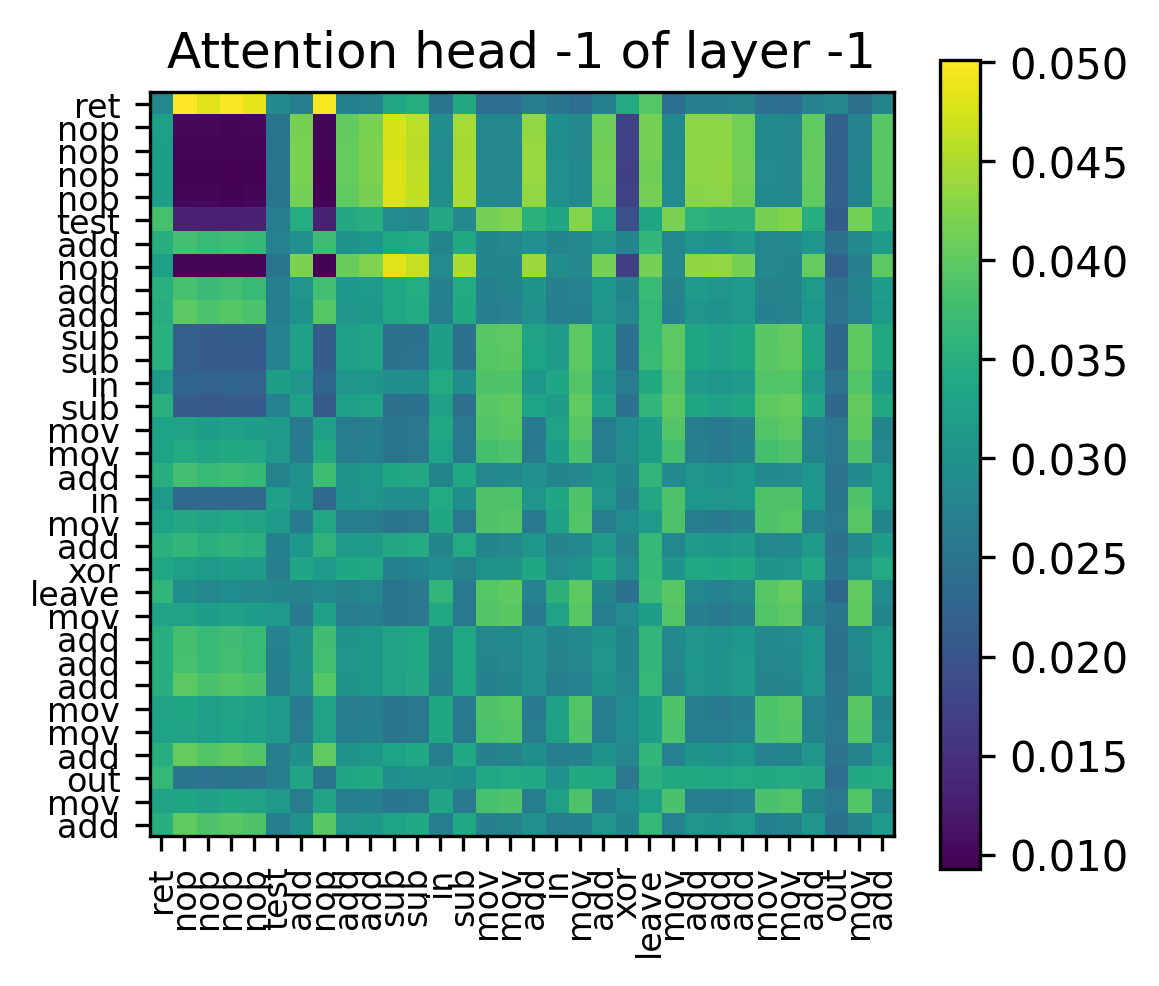

In [10]:
def plot_attention(model, sample, seq_idx = 0, head_idx = None, layer_idx = None):
    attention = get_attention(model, sample, tokenizer)

    if head_idx is None and layer_idx is None:  
        n_layers = len(attention)
        n_heads = model.config.num_attention_heads
        fig, axs = plt.subplots(n_heads, n_layers, dpi=300)
        fig.supxlabel("Attention Head")
        fig.supylabel("Layer")

        for layer in range(n_layers):
            for head in range(n_heads):
                sel = attention[layer][seq_idx, head].detach()
                axs[head, layer].imshow(sel)
                axs[head, layer].set_xticks([])
                axs[head, layer].set_yticks([])
    else: 
        sel = attention[layer_idx if layer_idx is not None else 0][seq_idx, head_idx if head_idx is not None else 0].detach()
        start = seq_idx * (model.config.max_position_embeddings - 2)
        end = start + (model.config.max_position_embeddings - 2)
        seq = sample['text'].split(' ')[start:end]
        plt.figure(dpi=300, figsize=(4,3.5))
        plt.title(f"Attention head {head_idx if head_idx is not None else 0} of layer {layer_idx if layer_idx is not None else 0}")
        plt.imshow(sel)
        plt.xticks(list(range(32)), seq, rotation=90, fontsize=8)
        plt.yticks(list(range(32)), seq, fontsize=8)
        plt.colorbar()

plot_attention(pretrained, dataset['test'][0], head_idx=-1, layer_idx=-1)
# plot_attention(base, dataset['test'][0], head_idx=None, layer_idx=None)

In [9]:
def attn_cosine_sim(A1, A2, l, h): 
    return torch.cosine_similarity(A1[l][:, h].flatten().unsqueeze(0), A2[l][:, h].flatten().unsqueeze(0)) 

def attn_D_kl(A1, A2, l, h):
    return torch.nn.functional.kl_div(A1[l][:, h], A2[l][:, h])

def attn_cka(A1, A2, l, h, T): 
    def cgram(X):
        X = X - X.mean(dim=0, keepdim=True)
        return X @ X.T

    A1 = A1[l][:, h, :, :].reshape(-1, T ** 2)
    A2 = A2[l][:, h, :, :].reshape(-1, T ** 2)

    A1_c = cgram(A1)
    A2_c = cgram(A2)

    HSIC = (A1_c * A2_c).sum()
    A1_norm = (A1_c * A1_c).sum().sqrt()
    A2_norm = (A2_c * A2_c).sum().sqrt()

    return HSIC / (A1_norm * A2_norm + 1e-12)

def attn_norm(A1, A2, l, h): 
    return torch.linalg.matrix_norm(A1[l][:, h, :, :] - A2[l][:, h, :, :]).mean()

def attn_entropy(A1, A2, l, h): 
    def entropy(A):
        A_c = A.clamp(min=1e-12)
        H = - (A_c * A_c.log()).sum(dim=1)
        return H.mean()

    H1 = entropy(A1[l][:, h, :, :])
    H2 = entropy(A2[l][:, h, :, :])

    return H1 - H2

def get_attention_similarity(sample):
    n_layers = base.config.num_hidden_layers
    n_heads = base.config.num_attention_heads
    T = base.config.max_position_embeddings - 2

    base_atn = get_attention(base, sample, max_len=100)
    pretrained_atn = get_attention(pretrained, sample, max_len=100)

    results = {
        "cosine": torch.zeros((n_layers, n_heads)), 
        "KL": torch.zeros((n_layers, n_heads)),  
        "CKA": torch.zeros((n_layers, n_heads)),  
        "F_norm": torch.zeros((n_layers, n_heads)),
        "entropy": torch.zeros((n_layers, n_heads))
    }

    for layer in range(n_layers):
        for head in range(n_heads):
            results['cosine'][layer, head] = attn_cosine_sim(base_atn, pretrained_atn, layer, head)
            results['KL'][layer, head] = attn_D_kl(base_atn, pretrained_atn, layer, head)
            results['CKA'][layer, head] = attn_cka(base_atn, pretrained_atn, layer, head, T)
            results['F_norm'][layer, head] = attn_norm(base_atn, pretrained_atn, layer, head)
            results['entropy'][layer, head] = attn_entropy(base_atn, pretrained_atn, layer, head)

    return results

results = []
for sample in tqdm(dataset['test'].select(range(100))): 
    r = get_attention_similarity(sample)
    results.append(r)

results = {
    "cosine": torch.stack([s['cosine'] for s in results]).mean(dim=0),
    "KL": torch.stack([s['KL'] for s in results]).mean(dim=0),
    "CKA": torch.stack([s['CKA'] for s in results]).mean(dim=0),
    "F_norm": torch.stack([s['F_norm'] for s in results]).mean(dim=0),
    "entropy": torch.stack([s['entropy'] for s in results]).mean(dim=0)
}

results

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


{'cosine': tensor([[0.7915, 0.7212],
         [0.4790, 0.3942],
         [0.5013, 0.3563],
         [0.3599, 0.6341],
         [0.4191, 0.4007],
         [0.5110, 0.4167],
         [0.5413, 0.6356]]),
 'KL': tensor([[-0.0990, -0.1006],
         [-0.0892, -0.0742],
         [-0.0997, -0.0934],
         [-0.0870, -0.0977],
         [-0.0926, -0.0828],
         [-0.0960, -0.0977],
         [-0.0929, -0.1016]]),
 'CKA': tensor([[0.4863, 0.4008],
         [0.6443, 0.5766],
         [0.5401, 0.6404],
         [0.5559, 0.6959],
         [0.3629, 0.3798],
         [0.3951, 0.3049],
         [0.2923, 0.2792]]),
 'F_norm': tensor([[0.7801, 0.8740],
         [1.6651, 2.2417],
         [1.4775, 1.8038],
         [1.9452, 1.2316],
         [1.7151, 2.0411],
         [1.4036, 1.6868],
         [1.3673, 1.0649]]),
 'entropy': tensor([[ 0.3048,  0.2266],
         [ 0.1650,  0.7303],
         [-0.1757, -0.0404],
         [ 0.3582, -0.0836],
         [ 0.0923,  0.3597],
         [ 0.1336, -0.2321],
    

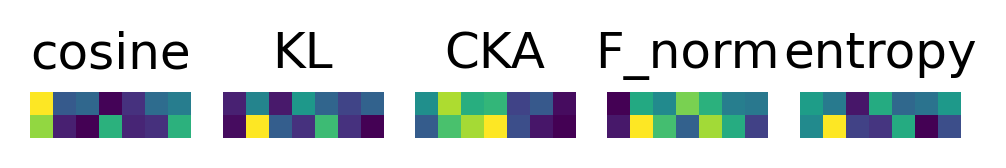

In [10]:
fig, axs = plt.subplots(1,5, dpi=300, figsize=(4,4))

for sim, ax in zip(results.keys(), axs.flatten()):
    ax.imshow(results[sim].detach().T)
    ax.axis('off')
    ax.title.set_text(sim)

In [5]:
malicious = []
benign = []

for sample in dataset['test'].select(range(10)):
    embeddings = get_embeddings(base, sample, tokenizer)

    if sample['label'] == 1: 
        malicious.append(embeddings)
    else: 
        benign.append(embeddings)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


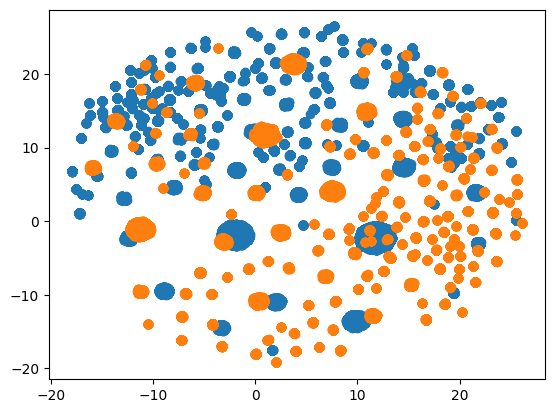

In [16]:
import umap 

a = umap.UMAP()
b = umap.UMAP()

a_hat = a.fit_transform(torch.cat(benign).reshape(-1, 128))
b_hat = b.fit_transform(torch.cat(malicious).reshape(-1, 128))

plt.scatter(a_hat[:, 0], a_hat[:, 1])
plt.scatter(b_hat[:, 0], b_hat[:, 1])


